# Environment Setup and Data Loading Preparation

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Nov  1 14:00:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   33C    P0             62W /  400W |     967MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 179.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import zipfile
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')



Mounted at /content/drive


# Data Loading and Preprocessing:

In [ ]:
# 1. Copy the data folder to the local disk (/content/)
!cp -rf '/content/drive/My Drive/research/model-v2/nutrition5k/preprocess/data.zip' /content/local_data

In [ ]:
# Unzip the data
!rm -rf /content/local_data/data
!unzip -o '/content/local_data/data.zip' -d '/content/local_data/data'

unzip:  cannot find or open /content/local_data/data.zip, /content/local_data/data.zip.zip or /content/local_data/data.zip.ZIP.


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import ast

In [ ]:
tf.__version__

'2.19.0'

In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
classes = pd.read_json('/content/drive/My Drive/research/model-v2/nutrition5k/preprocess/classes.json')
len(classes)

75

In [ ]:
classes.head(3)

,ingr,mass,count,mass_weight,count_weight
36,egg whites,47794.333297,200,1.000000,3.74500
48,chicken,46796.594974,400,1.021321,1.87250
33,scrambled eggs,39772.309517,331,1.201699,2.26284


In [ ]:
df = pd.read_json(
    '/content/drive/My Drive/research/model-v2/nutrition5k/preprocess/preprocessed_data.json',
    dtype={'label': 'str', 'total_mass': 'float64'}
)
df.head(3)

,id,total_calories,total_mass,total_fat,total_carb,total_protein,label,image_link,split
0,dish_1561662216,300.794281,193.0,12.387489,28.21829,18.63397,"['brown rice', 'pork', 'mixed greens']",./data/dish_1561662216/camera_A_frame_002.jpeg,test
1,dish_1561662216,300.794281,193.0,12.387489,28.21829,18.63397,"['brown rice', 'pork', 'mixed greens']",./data/dish_1561662216/camera_D_frame_002.jpeg,test
2,dish_1561662216,300.794281,193.0,12.387489,28.21829,18.63397,"['brown rice', 'pork', 'mixed greens']",./data/dish_1561662216/camera_C_frame_002.jpeg,test


In [ ]:
df['label'] = df['label'].apply(ast.literal_eval)

In [ ]:
directory = '/content/local_data/data/'
df['image_link'] = df['image_link'].apply(lambda x: os.path.join(directory, x.replace('./data/', '', 1)))

In [ ]:
df.head(3)

,id,total_calories,total_mass,total_fat,total_carb,total_protein,label,image_link,split
0,dish_1561662216,300.794281,193.0,12.387489,28.21829,18.63397,"[brown rice, pork, mixed greens]",/content/local_data/data/dish_1561662216/camer...,test
1,dish_1561662216,300.794281,193.0,12.387489,28.21829,18.63397,"[brown rice, pork, mixed greens]",/content/local_data/data/dish_1561662216/camer...,test
2,dish_1561662216,300.794281,193.0,12.387489,28.21829,18.63397,"[brown rice, pork, mixed greens]",/content/local_data/data/dish_1561662216/camer...,test


In [ ]:
df['image_link'][0]

'/content/local_data/data/dish_1561662216/camera_A_frame_002.jpeg'

# Resize Images

In [ ]:
x_col = 'image_link'
y_col = 'label'
image_size = 320
input_shape = (image_size, image_size, 3)
directory = '/content/local_data/data/'

# Train Test Split

In [ ]:
X_train = df[df['split'] == 'train']
X_test = df[df['split'] == 'test']
X_train.shape, X_test.shape

((49444, 9), (9879, 9))

In [ ]:
len(X_train.explode('label')['label'].unique()), len(X_test.explode('label')['label'].unique()), \
    set(X_train.explode('label')['label']) == set(X_test.explode('label')['label'])

(75, 74, False)

In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    shear_range=0.0,
    zoom_range=0.0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=45,
    brightness_range=(1, 1.5),
    fill_mode='nearest',
)

In [ ]:
class_list = list(classes['ingr'].values)
batch_size = 256

train_generator = image_generator.flow_from_dataframe(
    X_train,
    directory=directory,
    x_col=x_col,
    y_col=y_col,
    target_size=(image_size, image_size),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    classes=class_list,
    batch_size=batch_size,
)

Found 46753 validated image filenames belonging to 75 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2691 invalid image filename(s) in x_col="image_link". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
test_generator = image_generator.flow_from_dataframe(
    X_test,
    directory=directory,
    x_col=x_col,
    y_col=y_col,
    target_size=(image_size, image_size),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False,
    classes=class_list,
    batch_size=batch_size,
)

Found 9209 validated image filenames belonging to 75 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 670 invalid image filename(s) in x_col="image_link". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
train_classes = pd.DataFrame(train_generator.class_indices.items(), columns=['ingr', 'idx'])
train_classes.to_json('/content/drive/My Drive/research/model-v2/nutrition5k/image_model/class_encoding.json')
# joined_classes = train_classes.set_index('ingr').join(classes.set_index('ingr')).reset_index()
# class_weights_mass = dict(zip(joined_classes['idx'], joined_classes['mass_weight']))
# class_weights_count = dict(zip(joined_classes['idx'], joined_classes['count_weight']))

# Create Multi-label classification model based on EfficientNetV2B0

In [ ]:
def create_efficientnet_model():
    model = tf.keras.applications.EfficientNetV2B0(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    return model

In [ ]:
base_model = create_efficientnet_model()
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 320, 320,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 320, 320,  │          0 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 160, 160,  │        864 │ normalization_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 160, 160,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 160, 160,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 160, 160,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 160, 160,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 160, 160,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 80, 80,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 80, 80,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 80, 80,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 80, 80,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 80, 80,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 80, 80,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 80, 80,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 80, 80,    │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 5,858,704 (22.35 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [ ]:
def create_model(base_model):
    x = base_model.output
    x = tf.keras.layers.AveragePooling2D(
        padding='valid',
        strides=2,
        pool_size=(3, 3),
    )(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(
        1024,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4),
    )(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Dense(
        1024,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4),
    )(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    predictions = tf.keras.layers.Dense(len(train_generator.class_indices), activation='sigmoid')(x)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
    return model

In [ ]:
model = create_model(base_model)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 320, 320,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 320, 320,  │          0 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 160, 160,  │        864 │ normalization_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 160, 160,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 160, 160,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 160, 160,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 160, 160,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 160, 160,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 80, 80,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 80, 80,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 80, 80,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 80, 80,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 80, 80,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 80, 80,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 80, 80,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 80, 80,    │          0 │ block2b_expand_b

 Total params: 28,018,331 (106.88 MB)

 Trainable params: 27,957,723 (106.65 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [ ]:
def create_callbacks():
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=1,
        verbose=1,
        mode="auto",
        cooldown=0,
        min_lr=0,
    )
    return [
#         reduce_lr,
    ]

In [ ]:
learning_rate = 0.00008
epochs = 30

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
callbacks = create_callbacks()
loss = tf.keras.losses.BinaryCrossentropy()
metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model.compile(
    optimizer=opt,
    loss=loss,
    metrics=metrics,
)

# Train the model

In [ ]:
history = model.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=test_generator,
    callbacks=callbacks,
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 1593s 8s/step - accuracy: 0.1525 - auc: 0.6647 - loss: 2.2239 - prc: 0.0787 - precision: 0.0969 - recall: 0.0971 - val_accuracy: 0.5332 - val_auc: 0.9128 - val_loss: 1.0911 - val_prc: 0.5391 - val_precision: 0.8746 - val_recall: 0.2918
Epoch 2/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 1323s 7s/step - accuracy: 0.5592 - auc: 0.9354 - loss: 0.8773 - prc: 0.5742 - precision: 0.8292 - recall: 0.3467 - val_accuracy: 0.5516 - val_auc: 0.9418 - val_loss: 0.4629 - val_prc: 0.6406 - val_precision: 0.8568 - val_recall: 0.4295
Epoch 3/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 1312s 7s/step - accuracy: 0.6104 - auc: 0.9651 - loss: 0.3981 - prc: 0.7031 - precision: 0.8841 - recall: 0.4549 - val_accuracy: 0.5631 - val_auc: 0.9446 - val_loss: 0.2928 - val_prc: 0.6636 - val_precision: 0.8823 - val_recall: 0.4486
Epoch 4/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 1319s 7s/step - accuracy: 0.6253 - auc: 0.9723 - loss: 0.2624 - prc: 0.7440 - precision: 0.9013 - recall: 0.4977 - val_accuracy: 0.5

## Save Trained model data

In [ ]:
model.save('/content/drive/My Drive/research/model-v2/nutrition5k/models/ingredient_model_EfficientNetV2B0.keras')

In [ ]:
model.save('/content/local_data/models/ingredient_model_EfficientNetV2B0.keras')

In [ ]:
model = tf.keras.models.load_model('/content/local_data/models/ingredient_model_EfficientNetV2B0.keras')

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 496 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
history = pd.read_json('/content/drive/My Drive/research/model-v2/nutrition5k/image_model/history.json')
# history = history.history

# Plots for Evaluation

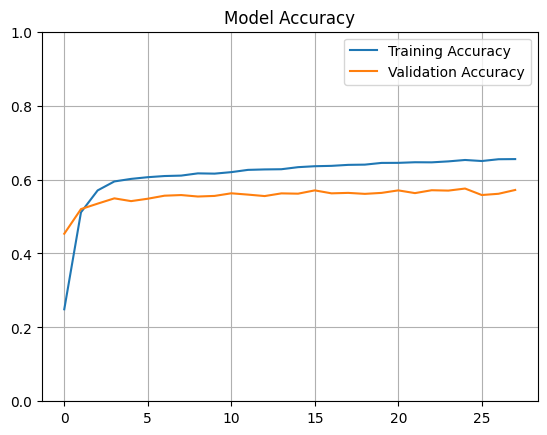

In [ ]:
import matplotlib.pyplot as plt

train_acc = history['accuracy']
val_acc = history['val_accuracy']

plt.title('Model Accuracy')
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.grid()
plt.legend()
plt.show()

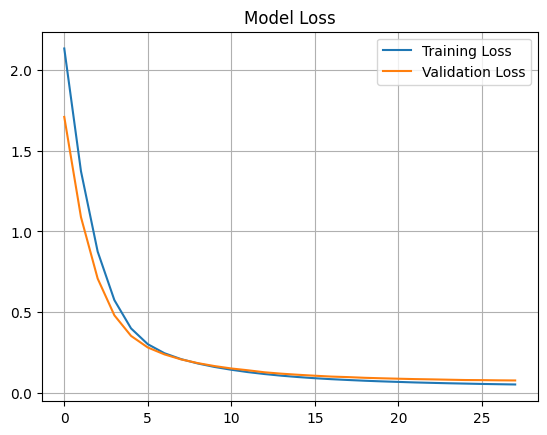

In [ ]:
train_loss = history['loss']
val_loss = history['val_loss']

plt.title('Model Loss')
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.grid()
plt.legend()
plt.show()

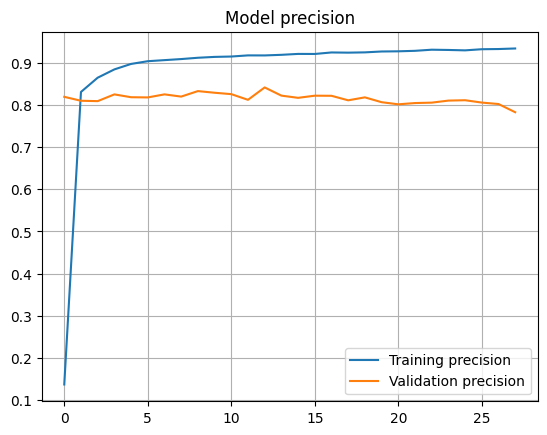

In [ ]:
train_precision = history['precision']
val_precision = history['val_precision']

plt.title('Model precision')
plt.plot(train_precision, label='Training precision')
plt.plot(val_precision, label='Validation precision')
plt.grid()
plt.legend()
plt.show()

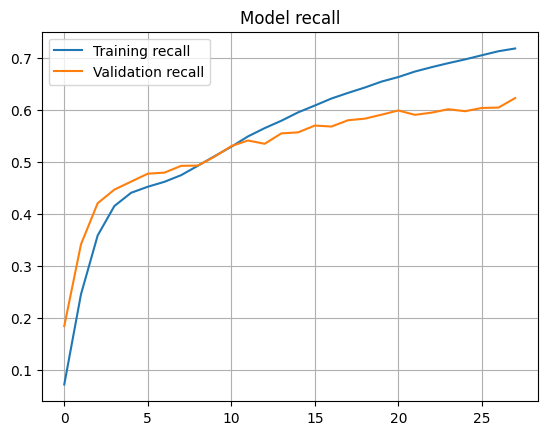

In [ ]:
train_recall = history['recall']
val_recall = history['val_recall']

plt.title('Model recall')
plt.plot(train_recall, label='Training recall')
plt.plot(val_recall, label='Validation recall')
plt.grid()
plt.legend()
plt.show()

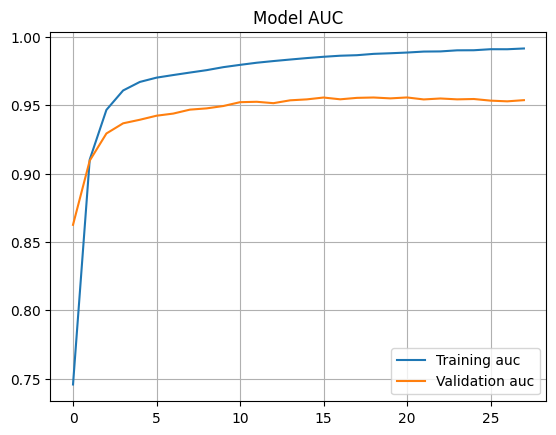

In [ ]:
train_auc = history['auc']
val_auc = history['val_auc']

plt.title('Model AUC')
plt.plot(train_auc, label='Training auc')
plt.plot(val_auc, label='Validation auc')
plt.grid()
plt.legend()
plt.show()

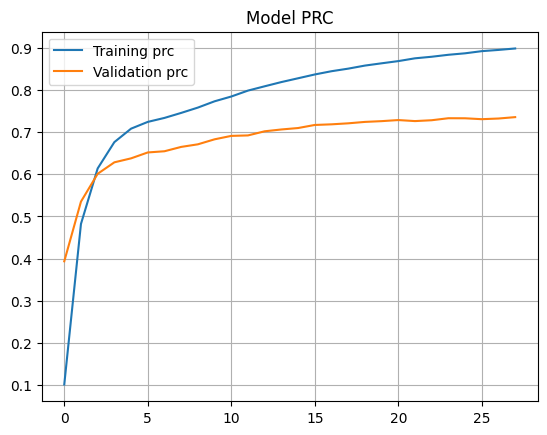

In [ ]:
train_prc = history['prc']
val_prc = history['val_prc']

plt.title('Model PRC')
plt.plot(train_prc, label='Training prc')
plt.plot(val_prc, label='Validation prc')
plt.grid()
plt.legend()
plt.show()

In [ ]:
def make_prediction(img):
    predictions = model.predict(img)
    label_index = {v: k for k,v in train_generator.class_indices.items()}
    indices = np.argsort(predictions[0])[::-1][:5]
    probs = [predictions[0][i] for i in indices]
    predicted_labels = [label_index[i] for i in indices]
    return predicted_labels, probs

In [ ]:
def random_img():
    item = df[df['split'] == 'test'].sample(1)
    img = tf.keras.utils.load_img(f"{item['image_link'].values[0]}")
    return item, img

# Make predicitions for a random image

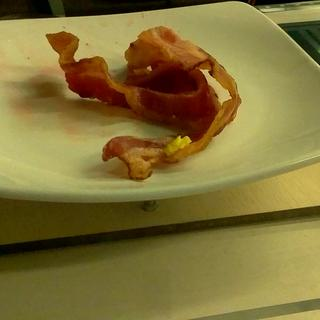

In [ ]:
item, img = random_img()
img

In [ ]:
item

,id,total_calories,total_mass,total_fat,total_carb,total_protein,label,image_link,split
19559,dish_1557937079,146.069992,27.0,11.339999,0.378,9.99,[bacon],/content/local_data/data/dish_1557937079/camer...,test


In [ ]:
x = np.array(img)
x = np.expand_dims(x, axis=0)
make_prediction(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


(['bacon', 'scrambled eggs', 'mixed greens', 'sausage', 'banana'],
 [np.float32(0.99881727),
  np.float32(0.0007511607),
  np.float32(0.0003234735),
  np.float32(0.0003170629),
  np.float32(0.0002721453)])